<a href="https://colab.research.google.com/github/caroldaza/DM_CyT/blob/main/TP2_revision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [3]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

import numpy as np
import pandas as pd   

!pip install networkx powerlaw community

import networkx as nx
import community
import powerlaw
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from sklearn.metrics import adjusted_rand_score

from networkx.algorithms.community import modularity
import community.community_louvain as community_louvain

# Carga de datos y limpieza

In [4]:
filename = '/content/drive/MyDrive/SWOW-EN.R100.csv.zip'
datos = pd.read_csv(filename, sep=',')
datos.head()

,Unnamed: 0,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,1,29,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,although,nevertheless,yet,but
1,2,30,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,deal,no,cards,shake
2,3,31,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,music,notes,band,rhythm
3,4,32,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,inform,tell,rat on,NaN
4,5,33,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,way,path,via,method


In [5]:
datos.shape

(1228200, 13)

In [6]:
# Nos quedamos solo con la cue y la primera palabra. Tambien botamos Nans
data_filt1 = datos.loc[:,['cue','R1']]
data = data_filt1.dropna(how='any')

# Sacar palabras de una letra
data.drop(data[data['cue'].str.len().lt(2)].index, inplace=True)
data.drop(data[data['R1'].str.len().lt(2)].index, inplace=True)

data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,cue,R1
0,although,nevertheless
1,deal,no
2,music,notes
3,inform,tell
4,way,path


In [7]:
data.shape

(1194119, 2)

In [8]:
# Sacar palabras R1 que no esten en cue y palabras en Cue que no esten en R1
data.drop(data[data['R1'].isin(data['cue'].unique())==False].index, inplace=True)
data.drop(data[data['cue'].isin(data['R1'].unique())==False].index, inplace=True)
data.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1060109, 2)

In [9]:
print(data[data['cue'] == data['R1']])

             cue       R1
30        Sunday   Sunday
317        again    again
801         okay     okay
1228        vote     vote
2709     produce  produce
...          ...      ...
1219525    rabbi    rabbi
1219814      led      led
1225477      fat      fat
1225489   things   things
1226968      for      for

[755 rows x 2 columns]


In [10]:
# Removiendo palabras que tiene igual cue y R1 para que no hayan loops
data.drop(data[data['cue'] == data['R1']].index, inplace=True)
data.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1059354, 2)

## Cargando palabras de W2V

In [11]:
# cargamos word2vec
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

w2v_model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

--2022-01-16 02:37:34--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.201.248
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.201.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.6’

GoogleNews-vectors- 100%[===================>]   1.53G  43.9MB/s    in 40s     

2022-01-16 02:38:14 (39.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.6’ saved [1647046227/1647046227]



In [12]:
# sacar cues que no esten en w2v
l = [w for w in data['cue'] if w not in w2v_model2.vocab]
data_w2v = data[-data['cue'].isin(l)]
print(data_w2v.shape[0]) 

1025170


In [13]:
# sacar R1 que no esten en w2v
l = [w for w in data_w2v['R1'] if w not in w2v_model2.vocab]
data_w2v = data_w2v[-data_w2v['R1'].isin(l)]
print(data_w2v.shape[0])

1015646


## Filtrado por frecuencia

In [14]:
# calculando frecuencia de aparicion de cada cue
df1 = data_w2v.groupby(['cue']).size().to_frame(name='size').reset_index()
df1_sorted = df1.sort_values(by=['size'],ascending=False).reset_index()
df1_sorted.tail(5)

,index,cue,size
11757,285,Spock,29
11758,10214,sundae,27
11759,475,adrenal,26
11760,278,Sherlock,23
11761,7818,pituitary,9


In [15]:
# calculando frecuencia de aparicion de cada R1
df2 = data_w2v.groupby(['R1']).size().to_frame(name='size').reset_index()
df2_sorted = df2.sort_values(by=['size'],ascending=False).reset_index()
df2_sorted.head(5)

,index,R1,size
0,6789,money,5796
1,4326,food,4678
2,11407,water,4381
3,1800,car,3804
4,6917,music,3290


In [16]:
# calculando frecuencia de aparicion de cada par cue-R1
df3 = data_w2v.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
df3_sorted = df3.sort_values(by=['size'],ascending=False).reset_index()
df3_sorted.head(5)

,index,cue,R1,size
0,1563,Cheddar,cheese,93
1,5896,Parmesan,cheese,92
2,212618,moo,cow,91
3,154034,halt,stop,87
4,214773,mozzarella,cheese,86


In [17]:
df3.shape[0]

368115

Cuantiles

In [18]:
df3['size'].quantile([.25, .5,.75, 0.95, 1])

0.25     1.0
0.50     1.0
0.75     2.0
0.95    10.0
1.00    93.0
Name: size, dtype: float64

Filtramos el 95%:

In [19]:
df3_rec = df3[df3['size'] > 10]
df3_rec.shape[0]


17089

Se calcula la frecuencia del par relativo a la frecuencia de aparición de R1:

In [20]:
df = df3_rec.merge(df2,left_on='R1',right_on='R1')
#df = df.merge(data_w2v,left_on=('cue','R1'),right_on=('cue','R1'))
df = df.rename(columns={'size_x':'frec_par','size_y':'frec_r1'})
df['weight'] = df['frec_par']/df['frec_r1']
df.head(10)

,cue,R1,frec_par,frec_r1,weight
0,Abel,Cain,55,62,0.887097
1,Aboriginal,Australia,29,325,0.089231
2,aborigine,Australia,39,325,0.120000
3,kangaroo,Australia,36,325,0.110769
4,outback,Australia,45,325,0.138462
5,wombat,Australia,22,325,0.067692
6,Aboriginal,native,23,232,0.099138
7,aborigine,native,23,232,0.099138
8,indigenous,native,46,232,0.198276
9,Adam,eve,71,89,0.797753


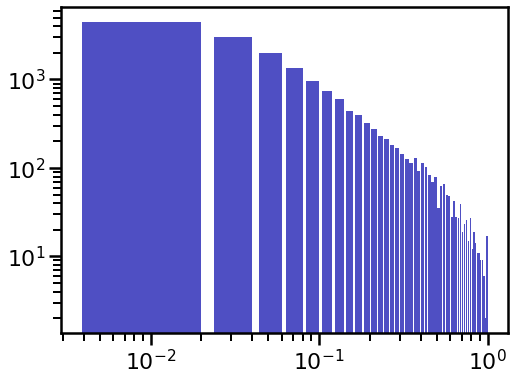

In [21]:
# distribucion frecuencias de pares (normalizada a R1)

import pylab as pl

pl.figure()
pl.hist(x=df['weight'], bins=50, log='TRUE', color='#0504aa', alpha=0.7, rwidth=0.8)
pl.gca().set_xscale("log")
plt.show()

Cuantiles de los pesos

In [22]:
df['weight'].quantile([.1, .25, .5, .75, 1])

0.10    0.010164
0.25    0.020742
0.50    0.051051
0.75    0.129278
1.00    1.000000
Name: weight, dtype: float64

In [23]:
# Recortando del grafo el primer cuartil

df_rec = df[(df['weight'] > 0.02)]
print(df_rec.shape[0])


12963


In [24]:
# Sacar otra vez palabras que no estan mas en el cue y la R1 y viceversa
df_rec.drop(df_rec[df_rec['R1'].isin(df_rec['cue'].unique())==False].index, inplace=True)
df_rec.drop(df_rec[df_rec['cue'].isin(df_rec['R1'].unique())==False].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Al recortar las parejas CUE-R1 que aparecen menos del 25% de las veces (y volviendo a pedir que las palabras CUE esten en R1 y viceversa), queda este número de palabras:

In [25]:
df_rec.shape[0]

4400

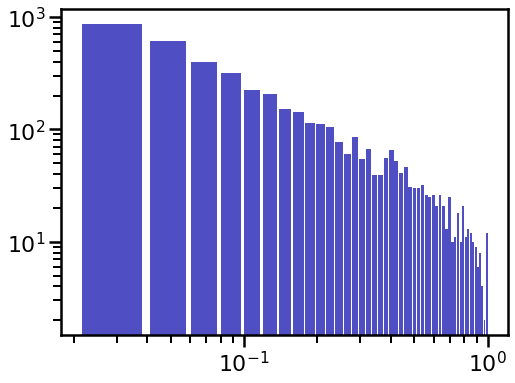

In [26]:
# distribucion frecuencias de pares (normalizada al CUE) recortada

import pylab as pl

pl.figure()
pl.hist(x=df_rec['weight'], bins=50, log=True, color='#0504aa', alpha=0.7, rwidth=0.85)
pl.gca().set_xscale("log")
plt.show()

Se podría ajustar con una ley de potencias (tiene un cutoff para valores grandes), pero se ven muchos nodos importantes al final de la cola (los valores en 10^0)

# Cálculo de grafo

In [27]:
df_sww = df_rec.drop_duplicates(subset=['cue','R1'], keep='first') # sacando duplicados si los hay
df_sww = df_sww.drop(['frec_par', 'frec_r1'], axis = 1) # sacando columnas innecesarias
df_sww

,cue,R1,weight
0,Abel,Cain,0.887097
9,Adam,eve,0.797753
16,cure,medicine,0.024845
21,pharmacy,medicine,0.026398
22,pill,medicine,0.026398
...,...,...,...
17078,yearning,longing,0.386667
17079,yelling,screaming,0.350000
17080,yelling,shouting,0.537037
17084,yucky,icky,0.159420


Calculando el grafo:

In [28]:
G=nx.from_pandas_edgelist(df = df_sww, source= 'cue', target= 'R1', edge_attr= 'weight', create_using=nx.DiGraph())

Nos quedamos con la componente conexa mas grande (la débilmente conectada para ser mas laxos):

In [29]:
S = [G.subgraph(c).copy() for c in [max(nx.weakly_connected_components(G), key=len)]]

print(G)
G1 = S[0]
print(G1)

DiGraph with 3335 nodes and 4400 edges
DiGraph with 1932 nodes and 2789 edges


Info del grafo:

In [30]:
print(nx.info(G1))

DiGraph with 1932 nodes and 2789 edges


In [31]:
# es pesado?
print('Is weigthed:',nx.is_weighted(G1))

Is weigthed: True


In [32]:
# Es dirigido
print('Is directed:',nx.is_directed(G1))

Is directed: True


In [33]:
# tiene loops?
print('There are loops:',nx.algorithms.is_directed_acyclic_graph(G1))

There are loops: False


In [34]:
# Están conectados?
print('Is connected:',nx.is_connected(G1.to_undirected()))

Is connected: True


Visualizando el grafo:

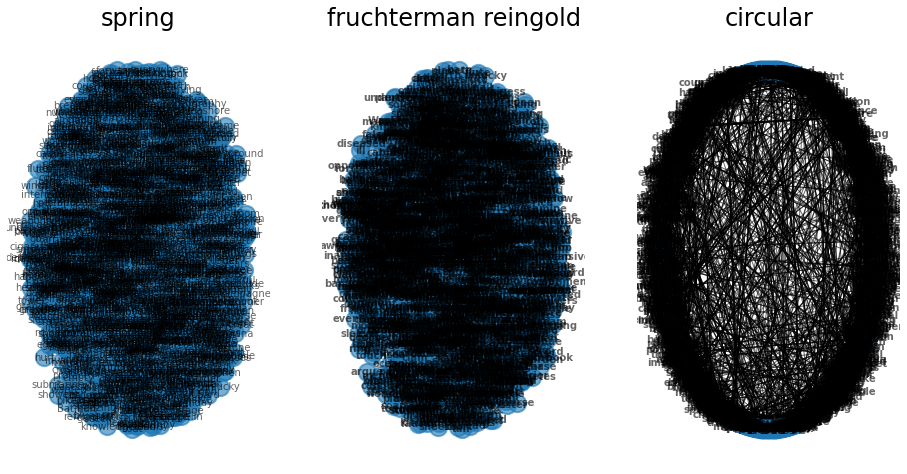

In [35]:
plt.figure(figsize=(16,8))

plt.subplot(131)
nx.draw(G1, with_labels=True, font_size=10, alpha=0.6)
plt.title('spring')

plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G1)
nx.draw(G1,layout, with_labels=True, font_weight='bold', font_size=10,alpha=0.6)
plt.title('fruchterman reingold')

plt.subplot(133)
layout=nx.circular_layout(G1)
nx.draw(G1,layout, with_labels=True, font_weight='bold', font_size=10,alpha=0.6)
plt.title('circular');

Como no se ve mucho, graficamos una red mas pequeña:

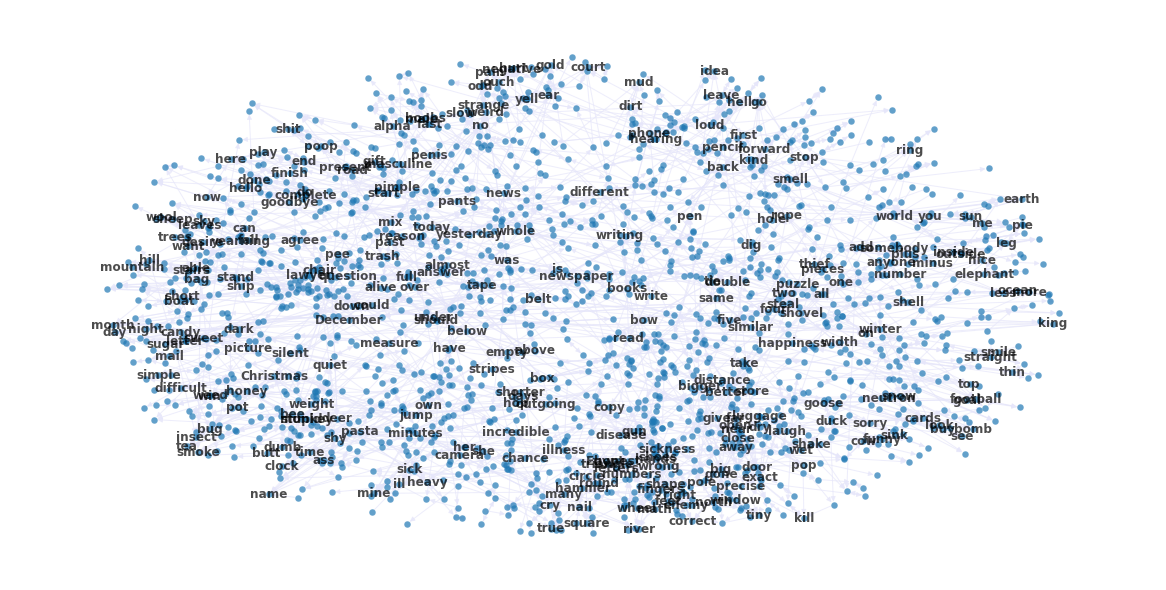

In [36]:
labels = {
    n: (n
        if len(list(nx.all_neighbors(G1, n))) >= 5 # nodos con 5 vecinos
        else '')
    for n in G1.nodes
}

plt.figure(figsize=(16,8))
layout=nx.fruchterman_reingold_layout(G1)
nx.draw(G1, layout, with_labels=True, labels=labels , alpha=0.7,
        font_weight='bold',font_color="black", font_size=12,  
        node_size=40,
        edge_color="lavender", linewidths=0.1) 

Se ve que palabras similares quedan juntas, por ejemplo plus, add y minus, hill y mountain, clock y time, pole y north etcetera.

Calculamos la distribución de grado del grafo:

In [37]:
df_grados_1 = pd.DataFrame(G1.degree,columns=['Node','Degree']).set_index('Node')
df_grados_1.sort_values('Degree',ascending=False).T

Node,gone,all,numbers,hello,mail,past,boat,cry,close,smell,shit,fall,go,Christmas,jump,month,same,bee,right,able,weight,far,weird,letter,nice,cow,now,stop,pot,better,pen,fingers,question,night,mine,short,have,cards,chair,dark,...,tennis,package,erection,leather,pair,twins,untie,pale,capacity,satisfied,hollow,curtain,storage,enthusiasm,blob,printer,cloud,clouds,blueberries,blueberry,superior,improvement,size,gigantic,bandage,railing,mostly,grain,embarrassed,basic,drain,excuse,ox,real,bells,doorbell,my,ownership,thoughtful,weekly
Degree,11,11,11,10,10,10,10,9,9,9,9,9,9,9,9,9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,7,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


<Figure size 720x288 with 0 Axes>

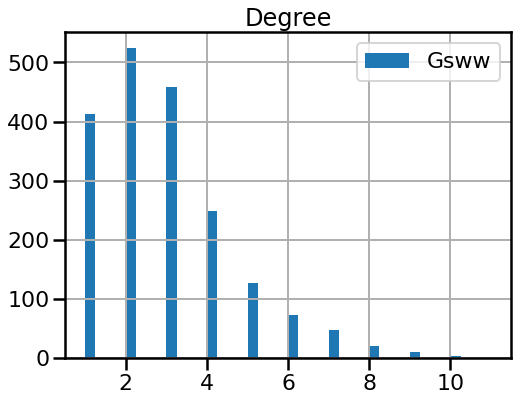

In [143]:
plt.figure(figsize=(10,4))
df_grados_1.hist(bins=40,label='Gsww')#,log=True)
#pl.gca().set_xscale("log")
plt.legend()


Se puede observar que el grafo tiene una distribución de grado de mundo pequeño.

Text(0.5, 1.0, 'Histograma pesos Gsww')

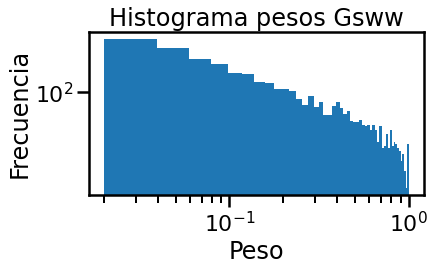

In [39]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.hist(df_sww.weight,bins=50,log=True)
pl.gca().set_xscale("log")
plt.ylabel('Frecuencia')
plt.xlabel('Peso');
plt.title('Histograma pesos Gsww')

Los pesos tienen una distribución aproximadamente de ley de potencias con un cutoff. Los pesos uno corresponden a valores de R1 que estan presentes en solo un par

Calculo número de aristas que tendría una red con cue + r1 palabras (con todas las palabras únicas)


In [81]:
df_aux1 = df_sww[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df_aux2 = df_sww[['R1']].rename(columns={'R1':'word'},inplace=False)

df_dict = pd.concat([df_aux1,df_aux2])  # concatenando
df_dict.shape

(8800, 1)

In [82]:
list_dict = df_dict['word'].unique() #eliminando duplicados
list_dict.shape

(3335,)

Para una red equivalente en nodos, el número de aristas en varios casos:

In [41]:
print('numero nodos',len(list_dict))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict)*(len(list_dict)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict)*(len(list_dict)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict)*(len(list_dict)))

numero nodos 3335
numero maximo aristas (no dirigidas y sin loops) 5559445.0
numero maximo aristas (dirigidas y sin loops) 11118890
numero maximo aristas (dirigidas y con loops) 11122225


El número de aristas de la red Gsww es de 4400 aristas, muy por debajo de una red equivalente donde los nodos esten todos conectados, sea dirigida o no. 
Entonces las conexiones son pocas y además la red tiene estructura (de mundo pequeño como se ve en la distribución de grado).

# Matriz de distancias

Se puede ver la intensidad con que estan conectados los nodos como una suerte de "similaridad". Podemos usar una distancia vista de este modo para visualizar si hay grupos de nodos con la matriz de adyacencia y con TSNE

In [42]:
df_sww.shape

(4400, 3)

Compruebo que no haya filas duplicadas

In [43]:
aux = df_sww.drop_duplicates(keep='first')

In [44]:
aux.shape

(4400, 3)

Armamos la matriz de adyacencia 

In [45]:
distancias_sww_dict=np.zeros((len(list_dict),len(list_dict))) #matriz cuadrada

diccionario = {elem: i for i, elem in enumerate(list_dict)}

for row in df_sww.iterrows():
  i = diccionario[row[1]['cue']]
  j = diccionario[row[1]['R1']]
  w = row[1]['weight']

  distancias_sww_dict[i,j] = w 


Quiero observar la disimilaridad:

In [46]:
distancias_sww_dict_aux = distancias_sww_dict

In [47]:
distancias_sww_dict = np.ones((len(list_dict),len(list_dict))) - distancias_sww_dict

Las diagonales deben ser cero

In [48]:
np.fill_diagonal(distancias_sww_dict,0)

In [49]:
4400/np.prod(distancias_sww_dict.shape)

0.00039560429680212365

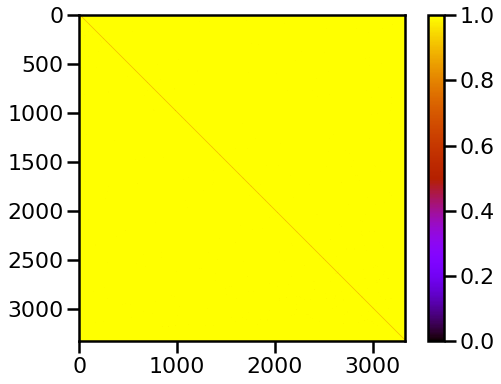

In [50]:
plt.imshow(distancias_sww_dict,cmap='gnuplot')
plt.colorbar()

No se ve nada porque es una matriz muy esparsa, alrededor de 3 celdas cada 10mil son distintas de cero

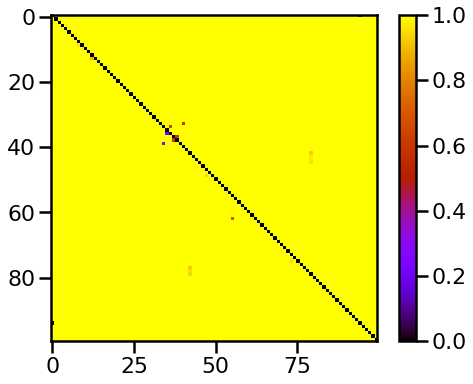

In [51]:
distancia_peque = distancias_sww_dict[0:100,0:100]
plt.imshow(distancia_peque,cmap='gnuplot')
plt.colorbar()

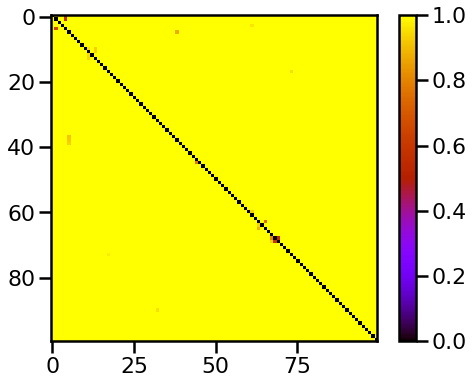

In [52]:
distancia_peque = distancias_sww_dict[1500:1600,1500:1600]
plt.imshow(distancia_peque,cmap='gnuplot')
plt.colorbar()

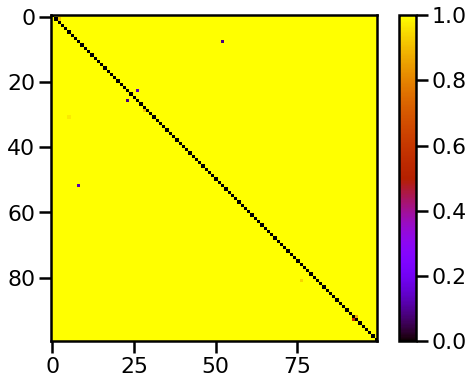

In [53]:
distancia_peque = distancias_sww_dict[2000:2100,2000:2100]
plt.imshow(distancia_peque,cmap='gnuplot')
plt.colorbar()

Hay pequeñas estructuras pero son difíciles de ver de esta manera

Usando TSNE para visualizar la red:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


Text(0.5, 1.0, 'TSNE')

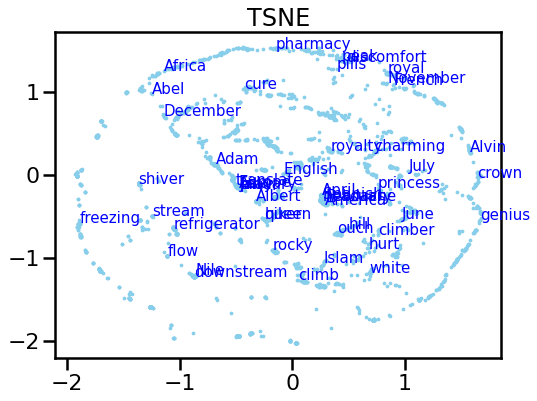

In [54]:
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE
# Reduccion de la dimensionalidad y visualizacion 
perplexity = 30
colores = ["blue"]*50
tsne = TSNE(n_components=2,metric="precomputed",learning_rate=100, random_state=123,perplexity=perplexity)
np.set_printoptions(suppress=True)

Y = tsne.fit_transform(distancias_sww_dict_aux)
plt.scatter(Y[:, 0], Y[:, 1],color="skyblue",s=3)
for label, x, y, color in zip(list_dict, Y[:, 0], Y[:, 1],colores):
    plt.annotate(label, xy=(x, y), xytext=(0, 0),textcoords='offset points' , color=color,size=15)
plt.title("TSNE")

Con el TSNE se notan mas los clusteres. Agrupa palabras similares, por ejemplo pills, pharmacy y discomfort o downstream, Nilo que tienen un camino hacia flow y de este a stream, o hill, climber y ouch (no pude lograr que no se superpusieran las palabras)

# Red Gw2v

Se usa el mismo conjunto de palabras filtradas de GoogleNews-vectors-negative300, el peso de las conexiones estará dado por la distancia entre las palabras. Esta distancia se define con la similaridad coseno que es simétrica, por ende la red será no dirigida.

Para crear esta red tomamos las mismas palabras filtradas anteriormente de 

In [55]:
distancias_w2v_dict=np.zeros((len(list_dict),len(list_dict))) #matriz cuadrada
t = time.time()
print('Total de pares de palabras %d'%(len(list_dict)*(len(list_dict)-1)/2))
for i,ti in enumerate(list_dict):
  if i % 1000 ==0:
    print('Palabra %d: %.2f secs'%(i,time.time()-t))
  for j,tj in enumerate(list_dict):
    if j>i:
      distancias_w2v_dict[i,j] = abs(1-w2v_model2.similarity(ti,tj)) # min 0 max 2, 0 mas disimilares, 1 ortogonales

Total de pares de palabras 5559445
Palabra 0: 0.00 secs
Palabra 1000: 70.78 secs
Palabra 2000: 117.87 secs
Palabra 3000: 139.97 secs


In [56]:
distancias_w2v_dict = distancias_w2v_dict + distancias_w2v_dict.T
print(distancias_w2v_dict.shape)

(3335, 3335)


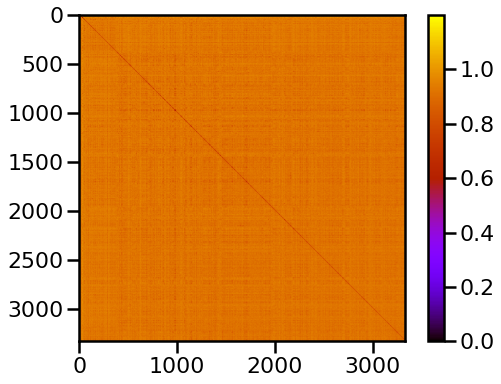

In [57]:
plt.imshow(distancias_w2v_dict,cmap='gnuplot')
plt.colorbar()

Probablemente entre 400 y 1000 y entre 1000 y 1900 hay clusteres pero son difíciles de ver porque las similaridades son pequeñas

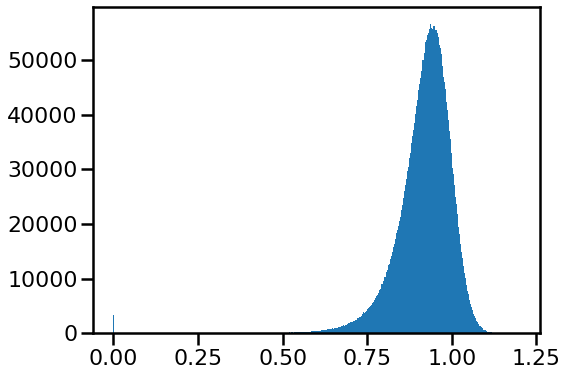

In [58]:
#El histograma de distancias
out = plt.hist(distancias_w2v_dict.flatten(),bins='auto')

Los valores con distancia 1 no son ni similares ni disimilares

Haciendo un zoom:

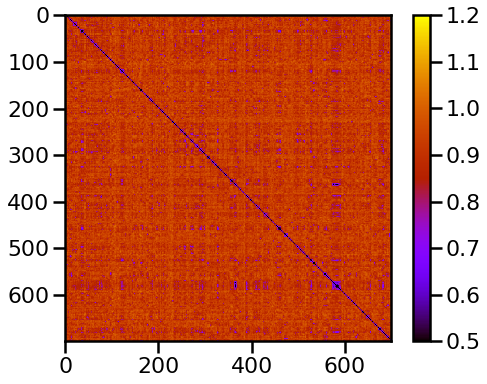

In [59]:
distancia_peque = distancias_w2v_dict[400:1100,400:1100]
plt.imshow(distancia_peque,cmap='gnuplot',vmin=0.5,vmax=1.2)
plt.colorbar()

Mas zoom:

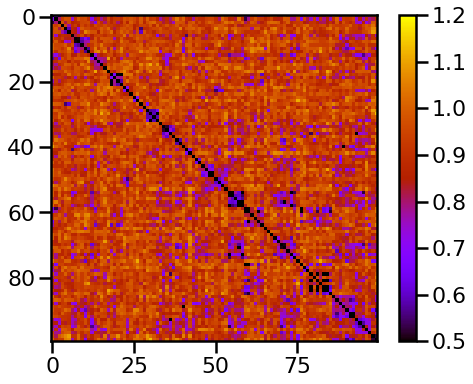

In [60]:
distancia_peque = distancias_w2v_dict[600:700,600:700]
plt.imshow(distancia_peque,cmap='gnuplot',vmin=0.5,vmax=1.2)
plt.colorbar()

Hay pequeñas estructuras locales.

# Calculo del grafo

Creando un dataset de la matriz de distancias:

In [61]:
df_w2v = pd.DataFrame(index=range(int((len(list_dict)*len(list_dict)+len(list_dict))/2)),columns=range(3))
df_w2v.rename(columns = {0:'word1', 1:'word2', 2:'weight'}, inplace = True)

u=0
for i in range(len(list_dict)):
  for j in range(len(list_dict)):
    if i<=j:
      df_w2v.iat[u,0] = list_dict[i]
      df_w2v.iat[u,1] = list_dict[j]
      df_w2v.iat[u,2] = distancias_w2v_dict[i,j]
      u=u+1


In [62]:
df_w2v

,word1,word2,weight
0,Abel,Abel,0
1,Abel,Adam,0.745152
2,Abel,cure,1.02182
3,Abel,pharmacy,0.91238
4,Abel,pill,1.00215
...,...,...,...
5562775,tension,cart,0.975001
5562776,tension,minion,1.01448
5562777,cart,cart,0
5562778,cart,minion,0.823105


Tirando registros con igua word1 y word2 para evitar loops

In [63]:
df_w2v.drop(df_w2v[df_w2v['word1'] == df_w2v['word2']].index, inplace=True)
df_w2v.shape

(5559445, 3)

In [86]:
df_w2v_short = df_w2v.sample(frac=0.1, random_state=1)
df_w2v_short

,word1,word2,weight
4023134,booth,massacre,1.07378
125565,July,nature,0.971825
2063603,naughty,amount,0.99168
4206013,spider,control,0.944119
2645283,skinny,unfinished,0.99264
...,...,...,...
4556385,cleanliness,relax,0.894331
333887,ocean,guard,1.01069
2014174,irritate,characteristic,0.806891
3613776,busy,gander,0.913293


Calculamos el grafo para esta red mas pequeña:

In [127]:
Gw2v=nx.from_pandas_edgelist(df = df_w2v_short, source= 'word1', target= 'word2', edge_attr= 'weight')

Info del grafo:

In [128]:
print(nx.info(Gw2v))

Graph with 3334 nodes and 80679 edges


In [129]:
# es pesado?
print('Is weigthed:',nx.is_weighted(Gw2v))

Is weigthed: True


In [130]:
# Es dirigido
print('Is directed:',nx.is_directed(Gw2v))

Is directed: False


In [132]:
# tiene loops?
print('There are loops:',nx.algorithms.is_directed_acyclic_graph(Gw2v))

There are loops: False


In [133]:
# Están conectados?
print('Is connected:',nx.is_connected(Gw2v))

Is connected: True


Veo si hay una componente conexa mas pequeña:

In [134]:
[len(c) for c in sorted(nx.connected_components(Gw2v), key=len, reverse=True)]

[3334]

No hay.

Visualizando esta red:

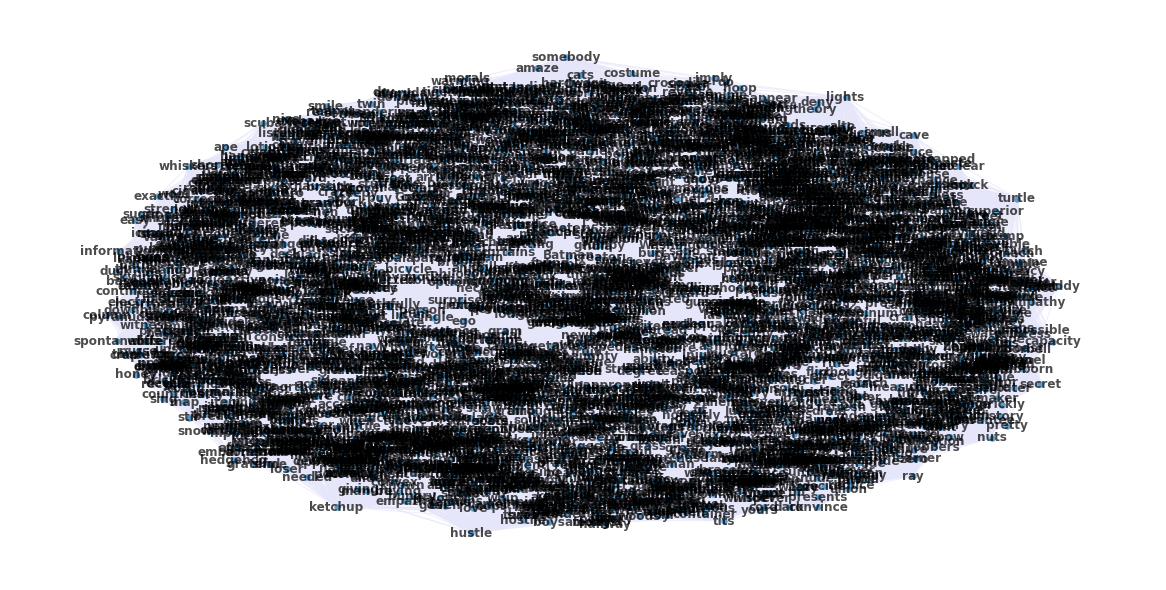

In [116]:
labels = {
    n: (n
        if len(list(nx.all_neighbors(Gw2v, n))) >= 10 # nodos con 10 vecinos
        else '')
    for n in Gw2v.nodes
}

plt.figure(figsize=(16,8))
#layout=nx.fruchterman_reingold_layout(Gw2v_short)
nx.draw(Gw2v, with_labels=True, labels=labels , alpha=0.7,
        font_weight='bold',font_color="black", font_size=12,  
        node_size=40,
        edge_color="lavender", linewidths=0.1)

Histograma de pesos de esta red:

Text(0.5, 1.0, 'Histograma pesos Gw2v')

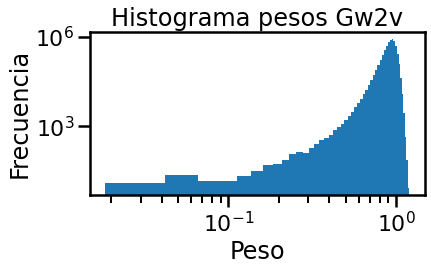

In [115]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.hist(df_w2v_short.weight,bins=50,log=True)
pl.gca().set_xscale("log")
plt.ylabel('Frecuencia')
plt.xlabel('Peso');
plt.title('Histograma pesos Gw2v')

In [123]:
# definiendo un umbral de pesos
#umbral_min = 0.70
#umbral_max = 0.75
#df_w2v_short_aux  = df_w2v_short.copy()
#df_w2v_short = df_w2v_short.loc[df_w2v_short["weight"]>= umbral_min, ]
#df_w2v_short_aux = df_w2v_short_aux.loc[df_w2v_short_aux["weight"]<= umbral_max, ]

#Gw2v_short =nx.from_pandas_edgelist(df = df_w2v_short_aux, source= 'word1',target= 'word2', edge_attr= 'weight')

Distribucion de grados:

In [135]:
df_grados_2 = pd.DataFrame(Gw2v_short.degree,columns=['Node','Degree']).set_index('Node')
df_grados_2.sort_values('Degree',ascending=False).T

Node,do,stupid,know,guess,maybe,hey,mad,crazy,not,cute,okay,probably,really,alright,so,funny,weird,shit,me,want,yummy,going,poo,honestly,laugh,guy,dumb,get,even,crap,fuck,if,always,dude,bum,stuff,obviously,afraid,mama,puke,...,Harley,chain,stage,Xerox,mortar,substitute,Holland,Davidson,bonds,fold,self,joint,control,royalty,void,cast,taker,grand,lines,delinquent,input,national,Cain,haystack,micro,circuit,clock,exchange,thrift,Omega,Washington,Edison,toll,operation,Newton,capital,hedge,gatherer,cranny,recall
Degree,310,280,276,270,257,256,251,243,233,233,229,229,228,227,224,223,220,215,213,213,212,211,209,206,205,205,204,204,202,201,200,195,194,193,193,191,190,190,190,188,...,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1


<Figure size 720x288 with 0 Axes>

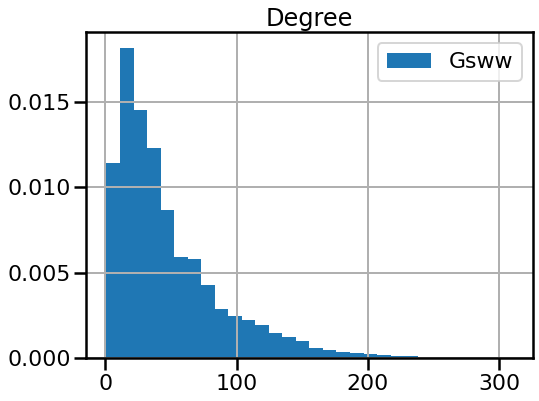

In [146]:
plt.figure(figsize=(10,4))
df_grados_2.hist(bins=30,density=True,label='Gsww')#,log=True)
#pl.gca().set_xscale("log")
plt.legend()


La distribucion de grado tambien parece de mundo pequeño

In [ ]:
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE
# Reduccion de la dimensionalidad y visualizacion 
perplexity = 30
colores = ["blue"]*50
tsne = TSNE(n_components=2,metric="precomputed",learning_rate=100, random_state=123,perplexity=perplexity)
np.set_printoptions(suppress=True)

Y = tsne.fit_transform(distancias_w2v_dict)
plt.scatter(Y[:, 0], Y[:, 1],color="skyblue",s=3)
for label, x, y, color in zip(list_dict, Y[:, 0], Y[:, 1],colores):
    plt.annotate(label, xy=(x, y), xytext=(0, 0),textcoords='offset points' , color=color,size=15)
plt.title("TSNE")